In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [10]:
def plot_line(gdf):
    x = gdf.geometry.x
    y = gdf.geometry.y

    plt.plot(x, y, linestyle="-")
    plt.axis("equal")

   track_fid  track_seg_id  track_seg_point_id    ele  \
0          0             0                   0  371.0   
1          0             0                   1  371.0   
2          0             0                   2  371.0   
3          0             0                   3  371.0   
4          0             0                   4  371.0   

                       time                  geometry  
0 2025-06-07 11:00:01+00:00  POINT (6.16168 46.22842)  
1 2025-06-07 11:00:10+00:00  POINT (6.16199 46.22833)  
2 2025-06-07 11:00:19+00:00  POINT (6.16229 46.22821)  
3 2025-06-07 11:00:28+00:00   POINT (6.16257 46.2281)  
4 2025-06-07 11:00:37+00:00    POINT (6.16286 46.228)  


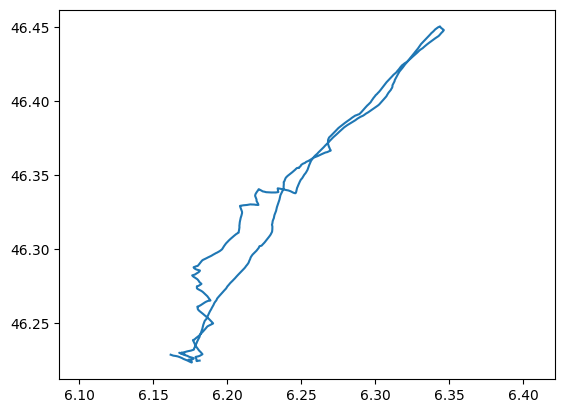

In [11]:
gdf = gpd.read_file("./raw_path.gpx", layer="track_points")
gdf = gdf.dropna(axis=1, how="all")

print(gdf.head(5))
plot_line(gdf)

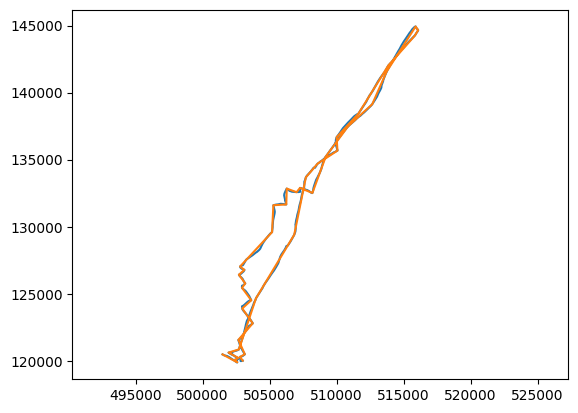

In [12]:
from shapely.geometry import LineString, Point

proj = gdf.to_crs(21781)
path = LineString(proj.geometry.tolist())
tolerance = 200
simple_line = path.simplify(tolerance, preserve_topology=False)
simple_points = [Point(c) for c in simple_line.coords]
simple_gdf = gpd.GeoDataFrame(geometry=simple_points, crs=proj.crs)
plot_line(proj)
plot_line(simple_gdf)

In [13]:
print(len(simple_gdf))

40


In [22]:
path_gdf = gpd.sjoin(simple_gdf, proj, how='left')
path_gdf.head()

,geometry,index_right,track_fid,track_seg_id,track_seg_point_id,ele,time
0,POINT (501485.415 120467.939),0,0,0,0,371.0,2025-06-07 11:00:01+00:00
1,POINT (502583.109 119879.674),52,0,0,52,371.0,2025-06-07 11:08:55+00:00
2,POINT (502416.324 120059.705),64,0,0,64,371.0,2025-06-07 11:11:46+00:00
3,POINT (502661.378 120202.061),80,0,0,80,371.0,2025-06-07 11:16:04+00:00
4,POINT (501934.479 120605.276),117,0,0,117,371.0,2025-06-07 11:24:46+00:00


In [60]:
import math
import pandas as pd
import numpy as np

def calculate_course(dx, dy):
    angle_rad = math.atan2(dx, dy) # dx first because the convention is angle clockwise, starting from y-axis
    angle_deg = math.degrees(angle_rad)
    return (angle_deg + 360) % 360 # [0, 360[

gdf = path_gdf
gdf["x"] = gdf.geometry.x
gdf["y"] = gdf.geometry.y
gdf["x_next"] = gdf["x"].shift(-1)
gdf["y_next"] = gdf["y"].shift(-1)
gdf["time_next"] = gdf["time"].shift(-1)
gdf = gdf[:-1].copy()

df = pd.DataFrame({
    "start_point": list(zip(round(gdf.x, 2), round(gdf.y, 2))),
    "end_point": list(zip(round(gdf.x_next, 2), round(gdf.y_next, 2))),
    "start_time": gdf.time,
    "end_time": gdf.time.shift(-1),
    "distance_m": round(np.sqrt((gdf['x_next'] - gdf['x'])**2 + (gdf['y_next'] - gdf['y'])**2), 2),
    "course_deg": round(gdf.apply(lambda row: calculate_course(row["x_next"] - row["x"], row["y_next"] - row["y"]), axis=1), 2),
})

df["duration_s"] = (df["end_time"] - df["start_time"]).dt.seconds
df["speed_ms"] = df.apply(lambda row: row["distance_m"] / row["duration_s"], axis=1)
df["speed_kts"] = round(df["speed_ms"] * 1.94384, 2)
o

df.head()

,start_point,end_point,start_time,end_time,distance_m,course_deg,duration_s,speed_ms,speed_kts
0,"(501485.42, 120467.94)","(502583.11, 119879.67)",2025-06-07 11:00:01+00:00,2025-06-07 11:08:55+00:00,1245.39,118.19,534.0,2.332191,4.53
1,"(502583.11, 119879.67)","(502416.32, 120059.71)",2025-06-07 11:08:55+00:00,2025-06-07 11:11:46+00:00,245.41,317.19,171.0,1.435146,2.79
2,"(502416.32, 120059.71)","(502661.38, 120202.06)",2025-06-07 11:11:46+00:00,2025-06-07 11:16:04+00:00,283.40,59.85,258.0,1.098450,2.14
3,"(502661.38, 120202.06)","(501934.48, 120605.28)",2025-06-07 11:16:04+00:00,2025-06-07 11:24:46+00:00,831.24,299.02,522.0,1.592414,3.10
4,"(501934.48, 120605.28)","(502701.95, 120838.02)",2025-06-07 11:24:46+00:00,2025-06-07 11:35:16+00:00,801.98,73.13,630.0,1.272984,2.47
